# Results analysis

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import pingouin
import os

from scipy.stats import wilcoxon
from pingouin import ttest
from scipy.spatial.distance import pdist


import numpy as np
import random
random.seed(123)
np.random.seed(123)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

## Constants

In [120]:
confidence_rate=0.05
ks=[8, 24, 48, 99]

spatial_regs=['wx', 'lag', 'error']    
n_spatial_reg=len(spatial_regs) 
metric_names=['SCM_features', 'SCM_labels', 'SCM_residuals']
model_combinations=[('swin', 'base', 'window7'), ('swinv2', 'base', 'window8'), 
        ('swinv2', 'base', 'window16'), ('swinv2', 'small', 'window8'), 
        ('swinv2', 'small', 'window16'), ('swinv2', 'tiny', 'window8'), 
        ('swinv2', 'tiny', 'window16'), ('resnetCLAM'), 
        ('vit')
    ]

model_combinations_formatted=[('_').join(model) if 'swin' in model[0] else model for model in model_combinations]
model_combinations_formatted=[model.replace('swin', 's').replace('window', 'w') for model in model_combinations_formatted]


PATH_tumor_stats='./tumor_stats'
PATH_regression_results='./regression_results/'
PATH_save_plots='./regression_results_plots/'

## Functions

In [121]:
def compute_average_distance(X):
    return np.mean(pdist(X))

In [122]:
def extract_from_df(df_p, col_name='filename', start_idx=4):
    df_p['model']=df_p[col_name].str.split("/").str[-1].str.split("_").str[start_idx]
    df_p["size"] = df_p[col_name].str.split("/").str[-1].str.split("_").str[start_idx+1]
    df_p["window_size"] = df_p[col_name].str.split("/").str[-1].str.split("_").str[start_idx+3]
    df_p['window_size'][~df_p.model.isin(['swinv2','swin'])]=''
    df_p['size'][~df_p.model.str.contains('swin')]=''
    df_p['k']= df_p[col_name].str.split("/").str[-1].str.split("_").str[1].astype(int)
    return df_p

In [123]:
from pingouin import ttest
def t_tests(df, p_vals): 
    df_0=df[df.label==0]
    df_1=df[df.label==1]
    for i, col in enumerate(metric_names):
        t=ttest( df_1[col], df_0[col], correction = False, alternative='greater')
        p_vals[i].append(t['p-val'][0]) 

    return p_vals 

In [124]:
import seaborn as sns
def plot_distribution(df, col_hue, model_name, agg='concat', split='test'):
    x_range=[]
    for metric in metric_names:
        df1=df.copy(deep=True)
        df1['label']=df1.label.map({0: 'normal', 1: 'tumor'})
        ax=sns.kdeplot(data=df1, x=metric, hue=col_hue, multiple="fill", common_norm=False, hue_order = ['normal', 'tumor'])
        x_range.append(ax.get_xlim())
        
    xmin=np.min([i[0] for i in x_range])
    xmax=np.max([i[1] for i in x_range])  
    
    for metric in metric_names: 
        df1=df.copy(deep=True)
        df1['label']=df1.label.map({0: 'normal', 1: 'tumor'})
        plt.figure(figsize=(6,4))
        ax=sns.kdeplot(data=df1, x=metric, hue=col_hue, multiple="fill", common_norm=False, hue_order = ['normal', 'tumor'])
        plt.xlabel('')
        ax.set_xlim(xmin, xmax)
        save_path=f"{PATH_save_plots}{split}/{agg}/{metric}/"
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plt.savefig(f"{save_path}{model_name}_{metric}.png", dpi=600, bbox_inches='tight', pad_inches=0.01)
        plt.close()

In [125]:
def pairwise(d_per_images, col, agg):
    values=[]
    d_per_images=extract_from_df(d_per_images, 'names_all_models')
    d_per_images=d_per_images[d_per_images.label==1] 
    
    model_combinations1=[model if type(model)==tuple else (model, '', '') for model in model_combinations]
        
    for model_n_size1 in model_combinations1:
        df_p1=d_per_images[(d_per_images['model']==model_n_size1[0]) & (d_per_images['size']==model_n_size1[1])
                          & (d_per_images['window_size']==model_n_size1[2])]
        
        df_p1=df_p1.sort_values(by='names_all_single')
        
        for model_n_size2 in model_combinations1:
            if model_n_size1==model_n_size2:
                p=1
            else:
                df_p2=d_per_images[(d_per_images['model']==model_n_size2[0]) & (d_per_images['size']==model_n_size2[1])
                                  & (d_per_images['window_size']==model_n_size2[2])]
                df_p2=df_p2.sort_values(by='names_all_single')
                
                if df_p1.shape[0]>df_p2.shape[0]:
                    bigger=df_p1
                    smaller=df_p2
                else:
                    bigger=df_p2
                    smaller=df_p1

                set_names=set(bigger.names_all_single).intersection(set(smaller.names_all_single))

                df_p1=df_p1[df_p1.names_all_single.isin(set_names)]
                df_p2=df_p2[df_p2.names_all_single.isin(set_names)]
                w,p = wilcoxon(df_p1[col], df_p2[col], alternative='greater' )
            values.append([model_n_size1, model_n_size2, p])


    z=[i[2] for i in values]
    l=int(np.sqrt(len(z)))
    z=np.array(z).reshape(l,l)

    plt.figure(figsize=(10,10))

    d=pd.DataFrame(z, index=model_combinations_formatted, columns=model_combinations_formatted)
    sns.heatmap(d, annot=True, square=True, cmap='seismic') 
    plt.title(f'p-value in pairwise test\n H0: mean of {col} of models on y-axis vs x-axis') 

    plt.savefig(f"{PATH_save_plots}heatmap_{reg}_{agg}.png", dpi=300, bbox_inches='tight', pad_inches=0.01)

In [126]:
def pairwise_features_labels(d_per_images, col_base='SCM_features', col_second='SCM_labels', per_k=True):
    values=[]
    
    d_per_images=extract_from_df(d_per_images, 'names_all_models')
    
    d_per_images=d_per_images[d_per_images.label==1]

    df = pd.DataFrame(columns=['model_name', 'k', 'p_value','mean_'+col_base, 'mean_'+col_second,
                               'max_'+col_base, 'max_'+col_second])
    
    model_combinations1=[model if type(model)==tuple else (model, '', '') for model in model_combinations]
    
    for i, model_n_size1 in enumerate(model_combinations1):
        df_p1=d_per_images[(d_per_images['model']==model_n_size1[0]) & (d_per_images['size']==model_n_size1[1])
                          & (d_per_images['window_size']==model_n_size1[2])]
        if per_k:
            for k in ks:
                df_p1_k=df_p1[df_p1.names_all_models.str.split('/').str[-1].str.contains("k_"+str(k))==True]

                w,p = wilcoxon(df_p1_k[col_base], df_p1_k[col_second], alternative='greater' )

                df.loc[len(df)] = [model_combinations_formatted[i], k, p, np.mean(df_p1_k[col_base]), np.mean(df_p1_k[col_second]),
                          np.max(df_p1_k[col_base]), np.max(df_p1_k[col_second])]
        else:
            w,p = wilcoxon(df_p1[col_base], df_p1[col_second], alternative='greater' )
            df.loc[len(df)] = [model_combinations_formatted[i], '-1', p, np.mean(df_p1[col_base]), np.mean(df_p1[col_second]),
                          np.max(df_p1[col_base]), np.max(df_p1[col_second])]

    return df

In [127]:
def mean_train_test(d_per_images_train, d_per_images_test, col='diff_wx'): 
    values=[]

    d_per_images_train=extract_from_df(d_per_images_train, 'names_all_models')
    d_per_images_train=d_per_images_train[d_per_images_train.label==1] 
    
    
    d_per_images_test=extract_from_df(d_per_images_test, 'names_all_models')
    d_per_images_test=d_per_images_test[d_per_images_test.label==1]
    
    model_combinations1=[model if type(model)==tuple else (model, '', '') for model in model_combinations]
    
    df = pd.DataFrame(columns=['model_name', 'k', 'p-value'])

    
    for i, model_n_size1 in enumerate(model_combinations1):    
                
        df_p1_train=d_per_images_train[(d_per_images_train['model']==model_n_size1[0]) 
                            &            (d_per_images_train['size']==model_n_size1[1])
                          & (d_per_images_train['window_size']==model_n_size1[2])]
        
        df_p1_test=d_per_images_test[(d_per_images_test['model']==model_n_size1[0])
                           &           (d_per_images_test['size']==model_n_size1[1])
                          & (d_per_images_test['window_size']==model_n_size1[2])]

        for k in ks:
            df_p1_k_train=df_p1_train[df_p1_train.names_all_models.str.split('/').str[-1].str.contains("k_"+str(k))==True]
            df_p1_k_test=df_p1_test[df_p1_test.names_all_models.str.split('/').str[-1].str.contains("k_"+str(k))==True]
            
            t=ttest(df_p1_k_train[col], df_p1_k_test[col], alternative='greater')

            df.loc[len(df)] = [model_combinations_formatted[i], k, t['p-val'][0]]
    return df

In [128]:
def aggregate_analyse_results(split, agg='concat'):
    """
    agg: mean, concat
    """
    counter=0
    p_vals=[[] for _ in range(n_spatial_reg)]   
    filelist_names=[]
    d_vals=[[] for _ in range(n_spatial_reg)]   
    names_all_single, names_all_models=[], []
    n_tumor_patches, tumor_patches_dist=[], []

    filelist_all_folds=[]
    counter_folds=0

    labels=[]
    dfs=[]

    for i in sorted(filelist):
        if counter_folds==0:
            results_folds=[]

        df=custom_read_csv(i, split=split)   
        d=df[df.Moran_p<0.05]
        df=df.sort_values(by='filename').reset_index(drop=True)

        results_folds.append(df)
        counter_folds+=1

        if counter_folds==5:
            counter_folds=0
            
            if agg=='concat':
                df=pd.concat(results_folds)

            elif agg=='mean':
                argmax_shape=np.argmax([len(results_folds[i].filename) for i in range(5)])
                indexes=list(set(range(5))-set([argmax_shape]))

                set_names=set(results_folds[argmax_shape].filename).intersection(set(results_folds[indexes[0]].filename), 
                                                                                 set(results_folds[indexes[1]].filename), 
                                              set(results_folds[indexes[2]].filename), set(results_folds[indexes[3]].filename))

                for j in range(5):
                    results_folds[j]=results_folds[j][results_folds[j].filename.isin(set_names)]
                    results_folds[j]=results_folds[j].sort_values(by='filename').reset_index(drop=True)

                df=pd.concat(results_folds).mean(level=0)
                df['filename']=results_folds[0].filename

            
            model_name= i.split('/')[-1].replace('_4.csv','')

            filelist_all_folds.append(model_name)

            df, d_vals =r2_differences(df, d_vals)

            names_all_single.extend(df.filename.values)
            names_all_models.extend([i]*df.shape[0])

            if "swinv2" in i: 
                n_tumor_patches, tumor_patches_dist=include_tumor_info(df, patches_per_tumor_256, 
                                                                               n_tumor_patches, tumor_patches_dist)
            else:
                n_tumor_patches, tumor_patches_dist=include_tumor_info(df, patches_per_tumor_224, 
                                                                               n_tumor_patches, tumor_patches_dist)

            for reg in spatial_regs:
                plot_distribution(df, "label", model_name, 'concat', split)

            p_vals=t_tests(df, p_vals)  
            dfs.append(df)
            labels.extend(df.label)
 
    df_p=pd.DataFrame({'filename': filelist_all_folds, 'p_val_diff_wx': p_vals[0], 'p_val_diff_lag': p_vals[1],
                       'p_val_diff_error': p_vals[2]
                      })
    d_per_images=pd.DataFrame({'names_all_models': names_all_models, metric_names[0]: d_vals[0], metric_names[1]: d_vals[1], 
                               metric_names[2]: d_vals[2], 'names_all_single': names_all_single, 
                               'n_tumor_patches': n_tumor_patches, 'tumor_patches_dist':tumor_patches_dist, 'label': labels
                              })
    return df_p, d_per_images, dfs

In [129]:
def custom_read_csv(path, split='test'):
    """
    if split is different that 'train' and 'test' then whole file is loaded (train+test)
    """
    df=pd.read_csv(path)
    df=df.drop_duplicates(subset='filename', keep='last') 
    df=df[df.wx_r2!=-100] # -100 was used to indicate that regression was not perform to due to few features
                            #compared to the number of patches (mostly in Wx)'
    if split=='test':
        df=df[df['filename'].str.contains(split) ==True]
    elif split=='train':
        df=df[df['filename'].str.contains('test') ==False]
    return df

In [130]:
def r2_differences(df, d_values):
    for i, col in enumerate(spatial_regs):
        df[metric_names[i]]=df[col+'_r2'] - df.r2
        d_values[i].extend(df[metric_names[i]])

    return df, d_values 

In [131]:
def include_tumor_info(df, patches_per_tumor, n_tumor_patches, tumor_patches_dist):
    data=[]
    for i in range(2):
        data.append([patches_per_tumor[x][i] if x in patches_per_tumor else 0
                                for x in 
                                df['filename'].str.split('.').str[0] ])
    n_tumor_patches.extend(data[0])
    tumor_patches_dist.extend(data[1])
 
    return n_tumor_patches, tumor_patches_dist

In [132]:
def get_annot(PATH_tumor_stats, patch_size):
    annot_train= glob.glob(f"{PATH_tumor_stats}/training/{patch_size}/*.csv")
    annot_test= glob.glob(f"{PATH_tumor_stats}/testing/{patch_size}/*.csv")
    annot=annot_train+annot_test
    return annot

In [133]:
def get_tumor_data(patches_per_tumor, annot):
    for file in annot:
        df=pd.read_csv(file)
        patches_per_tumor[("_").join(file.split("/")[-1].
                                     split('_')[:2])+"_blockmap"] = [np.sum(df.ill_cells_area>0), 
                                                                    compute_average_distance(
                                                                            df.loc[:,['patch_top_left_x', 
                                                                                  'patch_top_left_y']])] 
    return patches_per_tumor

## Analysis

In [134]:
annot_224=get_annot(PATH_tumor_stats, 224)
annot_256=get_annot(PATH_tumor_stats, 256)

patches_per_tumor_256={}
patches_per_tumor_224={}

patches_per_tumor_224=get_tumor_data(patches_per_tumor_224, annot_224)
patches_per_tumor_256=get_tumor_data(patches_per_tumor_256, annot_256)

### Load files with regression results

In [135]:
filelist=glob.glob(PATH_regression_results+"*.csv")

### Check in how many cases *p*-value in Global Moran's I test is below confidence_rate

In [136]:
total=0
Moran_significant=0
for i in sorted(filelist):
    df=custom_read_csv(i, split='test')   
    total+=df.shape[0]
    d=df[df.Moran_p<0.05]
    Moran_significant+=d.shape[0]
    
print(Moran_significant/total)  

0.9938412506998578


### Check how many features remained after dropping out the correlated ones

In [137]:
dict_corr={}
for i in sorted(filelist)[:9*5]:
    df=custom_read_csv(i, split='test')   
    df=df[df.Moran_p<0.05]
    model_name= ('_').join(i.split('/')[-1].split('_')[:-1]).replace('.csv','')
    if model_name not in dict_corr.keys():
        dict_corr[model_name]=list(df.n_correlated)
    else:
        dict_corr[model_name].extend(df.n_correlated.values)
        
for k,v in dict_corr.items():
    if "tiny" in k or "small" in k:
        feature_size=768
    else:
        feature_size=1024
    dict_corr[k]=feature_size-np.mean(v)
        

In [138]:
dict_corr

{'k_24_CAMELYON16_224_resnetCLAM_weighted_50_0.0002_1e-05_adam_0.7_False_0.25_10_50_True_512_256': 409.85426356589153,
 'k_24_CAMELYON16_224_swin_base_patch4_window7_224_22k_weighted_50_0.005_0.0_sgd_0.7_False_0.25_10_50_True_512_128': 754.7577639751553,
 'k_24_CAMELYON16_224_vit_weighted_50_0.005_0.0_sgd_0.7_False_0.25_10_50_True_512_128': 703.2325581395348,
 'k_24_CAMELYON16_256_swinv2_base_patch4_window16_256_weighted_50_0.005_0.0_sgd_0.7_False_0.25_10_50_True_512_128': 747.1300940438871,
 'k_24_CAMELYON16_256_swinv2_base_patch4_window8_256_weighted_50_0.005_0.0_sgd_0.7_False_0.25_10_50_True_512_128': 735.6640746500777,
 'k_24_CAMELYON16_256_swinv2_small_patch4_window16_256_weighted_50_0.005_0.0_sgd_0.7_False_0.25_10_50_True_512_128': 571.8953125,
 'k_24_CAMELYON16_256_swinv2_small_patch4_window8_256_weighted_50_0.005_0.0_sgd_0.7_False_0.25_10_50_True_512_128': 576.8055987558321,
 'k_24_CAMELYON16_256_swinv2_tiny_patch4_window16_256_weighted_50_0.005_0.0_sgd_0.7_False_0.25_10_50_Tru

## Aggregate results from folds (CONCATENATION)

In [139]:
df_p_test, d_per_images_test, dfs_test = aggregate_analyse_results('test', 'concat')
df_p_train, d_per_images_train, df_train = aggregate_analyse_results('train', 'concat')

### The pairwise comparison of mean spatial context measures for different DL models

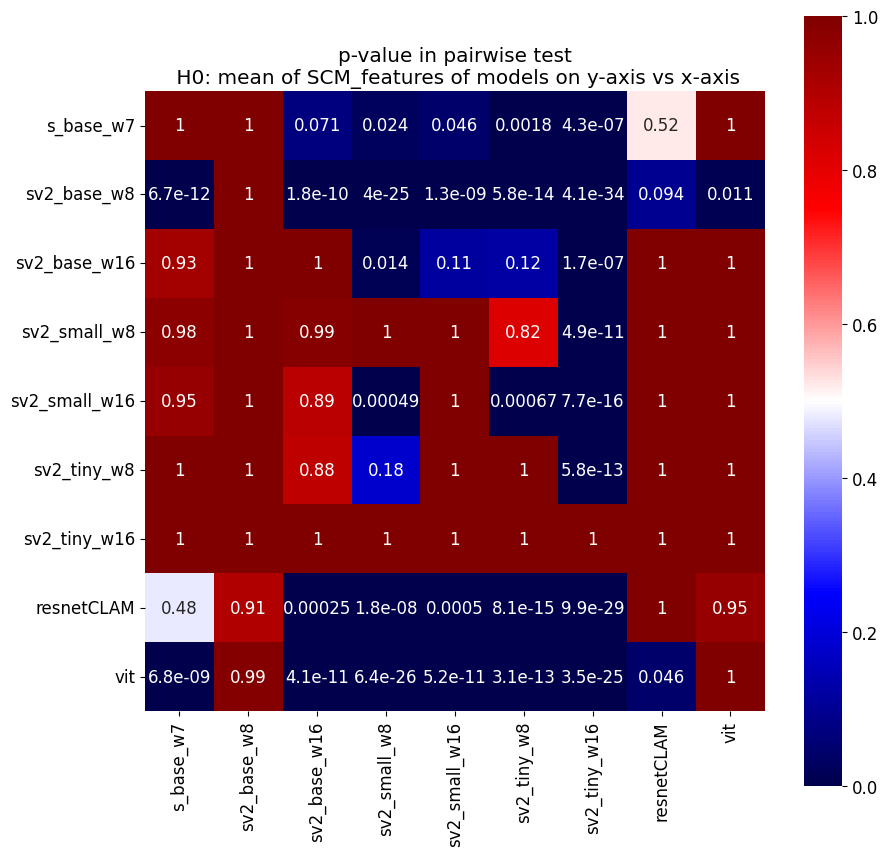

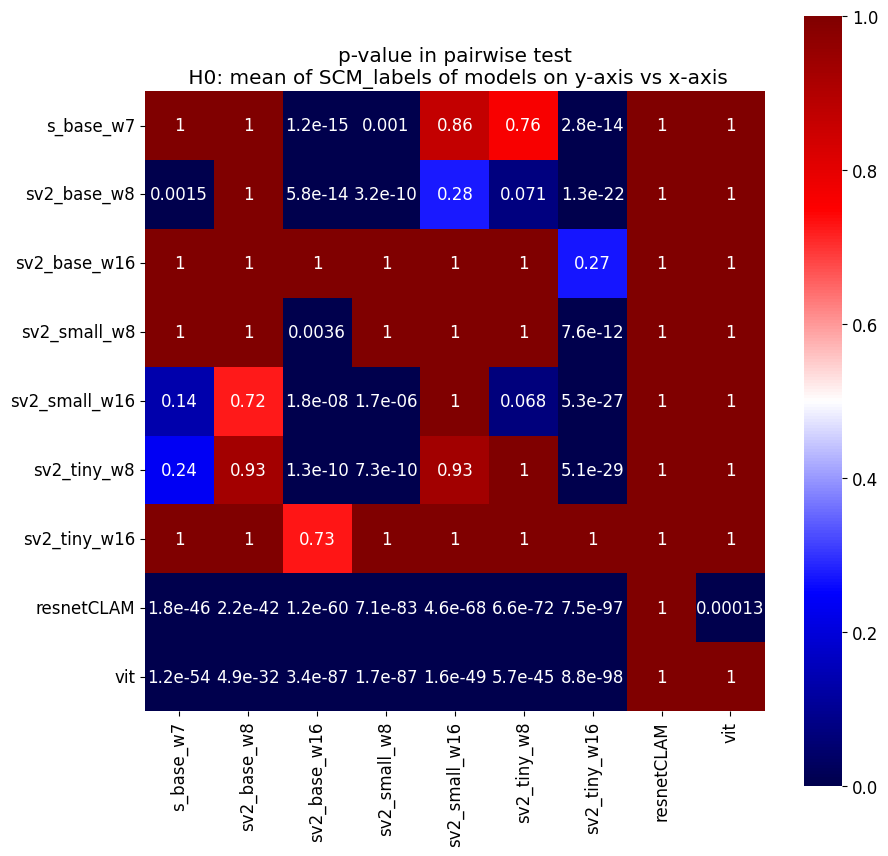

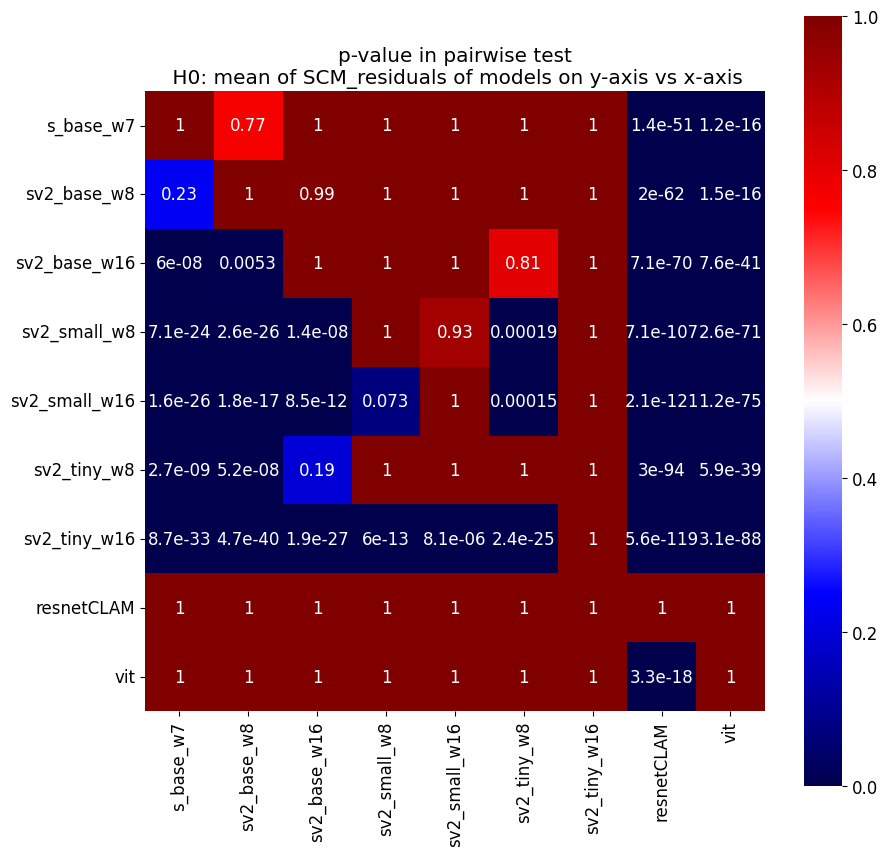

In [140]:
for metric in metric_names: 
    pairwise(d_per_images_test, metric, 'concat')

### Check in how many cases spatial context measures on train set are bigger than on test set

In [141]:
for metric in metric_names:
    d_train_test_p=mean_train_test(d_per_images_train, d_per_images_test, col=metric)
    percent_cases=d_train_test_p[d_train_test_p['p-value']<0.05].shape[0]/d_train_test_p.shape[0]
    print(f'percent of cases when the diff between mean {metric} on train is greater than on test set:{percent_cases}')

percent of cases when the diff between mean SCM_features on train is greater than on test set:0.8611111111111112
percent of cases when the diff between mean SCM_labels on train is greater than on test set:0.8888888888888888
percent of cases when the diff between mean SCM_residuals on train is greater than on test set:0.0


### Check whether SCM_features is bigger than SCM_labels

In [142]:
df_pairwise_features_labels_k=pairwise_features_labels(d_per_images_test, per_k=True)
df_pairwise_features_labels=pairwise_features_labels(d_per_images_test, per_k=False)

In [143]:
df_pairwise_features_labels.sort_values(by='mean_SCM_features', ascending=False, inplace=False).drop('k', axis=1)   #P-VALUE CHECKS WHETHER WX IS BIGGER THAN LAG

,model_name,p_value,mean_SCM_features,mean_SCM_labels,max_SCM_features,max_SCM_labels
1,sv2_base_w8,3.037081e-162,0.006718,0.002214,0.047946,0.034298
8,vit,6.086387e-162,0.006318,0.003054,0.041311,0.030274
7,resnetCLAM,3.046400e-162,0.005832,0.002889,0.045470,0.040208
0,s_base_w7,3.037081e-162,0.005617,0.001792,0.041427,0.024280
2,sv2_base_w16,3.037081e-162,0.005544,0.001564,0.038163,0.022733
4,sv2_small_w16,3.037081e-162,0.005020,0.001336,0.033175,0.016488
5,sv2_tiny_w8,3.037081e-162,0.004990,0.001499,0.034034,0.021154
3,sv2_small_w8,3.037081e-162,0.004695,0.001323,0.029688,0.024000
6,sv2_tiny_w16,3.037081e-162,0.004455,0.001208,0.045352,0.030641


In [144]:
df_pairwise_features_labels.sort_values(by='mean_SCM_labels', ascending=False).drop('k', axis=1) 

,model_name,p_value,mean_SCM_features,mean_SCM_labels,max_SCM_features,max_SCM_labels
8,vit,6.086387e-162,0.006318,0.003054,0.041311,0.030274
7,resnetCLAM,3.046400e-162,0.005832,0.002889,0.045470,0.040208
1,sv2_base_w8,3.037081e-162,0.006718,0.002214,0.047946,0.034298
0,s_base_w7,3.037081e-162,0.005617,0.001792,0.041427,0.024280
2,sv2_base_w16,3.037081e-162,0.005544,0.001564,0.038163,0.022733
5,sv2_tiny_w8,3.037081e-162,0.004990,0.001499,0.034034,0.021154
4,sv2_small_w16,3.037081e-162,0.005020,0.001336,0.033175,0.016488
3,sv2_small_w8,3.037081e-162,0.004695,0.001323,0.029688,0.024000
6,sv2_tiny_w16,3.037081e-162,0.004455,0.001208,0.045352,0.030641


In [145]:
def k_vs_metric(agg='mean'):
    """
    agg: 'mean', 'max'
    """
    n_ks=len(ks)
    fig, (ax1, ax2)=plt.subplots(1,2, figsize=(6, 3), sharey=True, sharex=True)
    for i, col in enumerate(metric_names[:2]):
        if agg=='max':
            idx=i+5
        else:
            idx=i+3
        ax = ax1 if i ==0 else ax2
        for model_idx in range(0, df_pairwise_features_labels_k.shape[0], n_ks):
            ax.plot(df_pairwise_features_labels_k.iloc[model_idx:(model_idx+n_ks), 1], 
                    df_pairwise_features_labels_k.iloc[model_idx:(model_idx+n_ks),idx], '-o')
        ax.set_title(f'{agg} {col}')

        fig.legend(model_combinations_formatted, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3) 

        ax.set_xticks(ks)
        ax.set_xlabel('k')

    plt.savefig(f'{PATH_save_plots}{agg}_diff_vs_k.png', dpi=300, bbox_inches='tight')

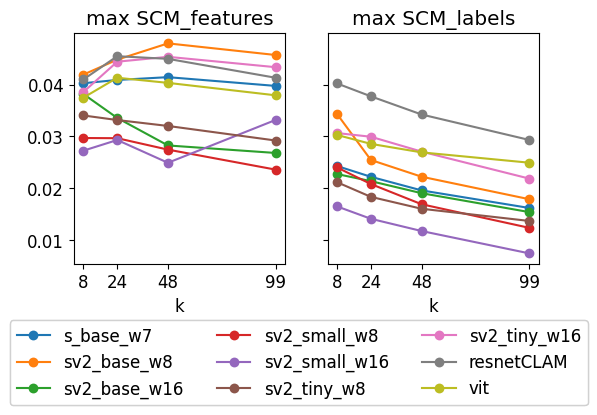

In [146]:
k_vs_metric(agg='max')

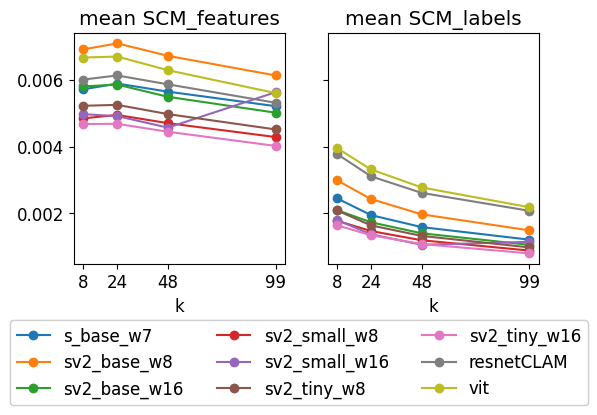

In [147]:
k_vs_metric(agg='mean')

## Aggregate results from folds (MEAN)  

In [148]:
df_p_test, d_per_images_test, dfs_test= aggregate_analyse_results('test', 'mean')
df_p_train, d_per_images_train, dfs_train= aggregate_analyse_results('train', 'mean')

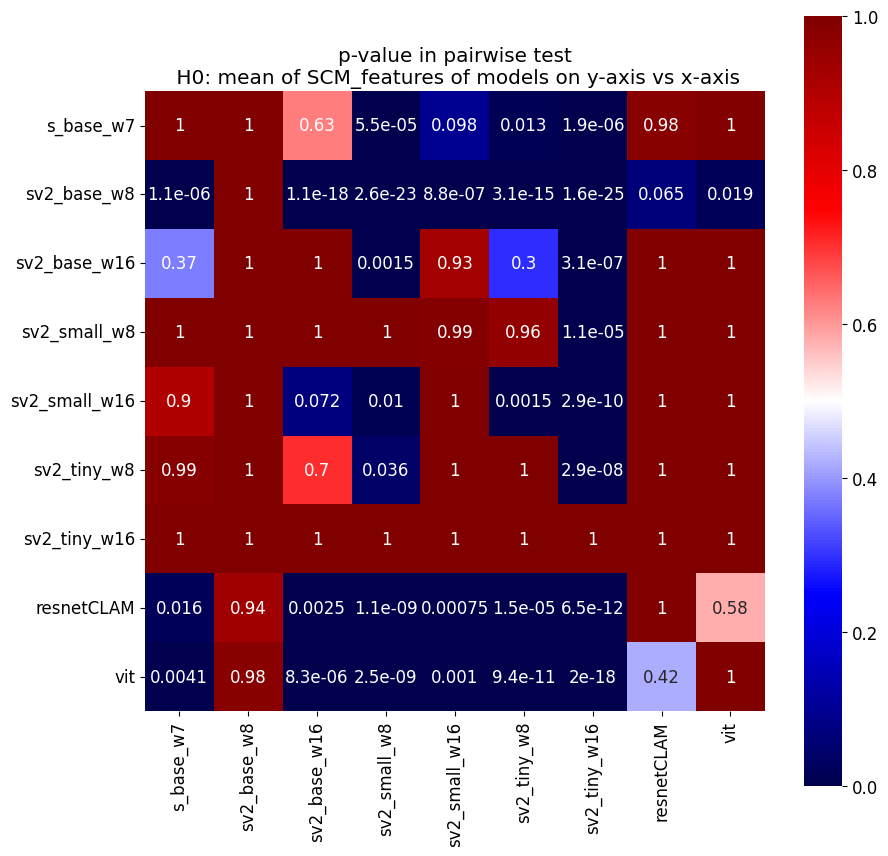

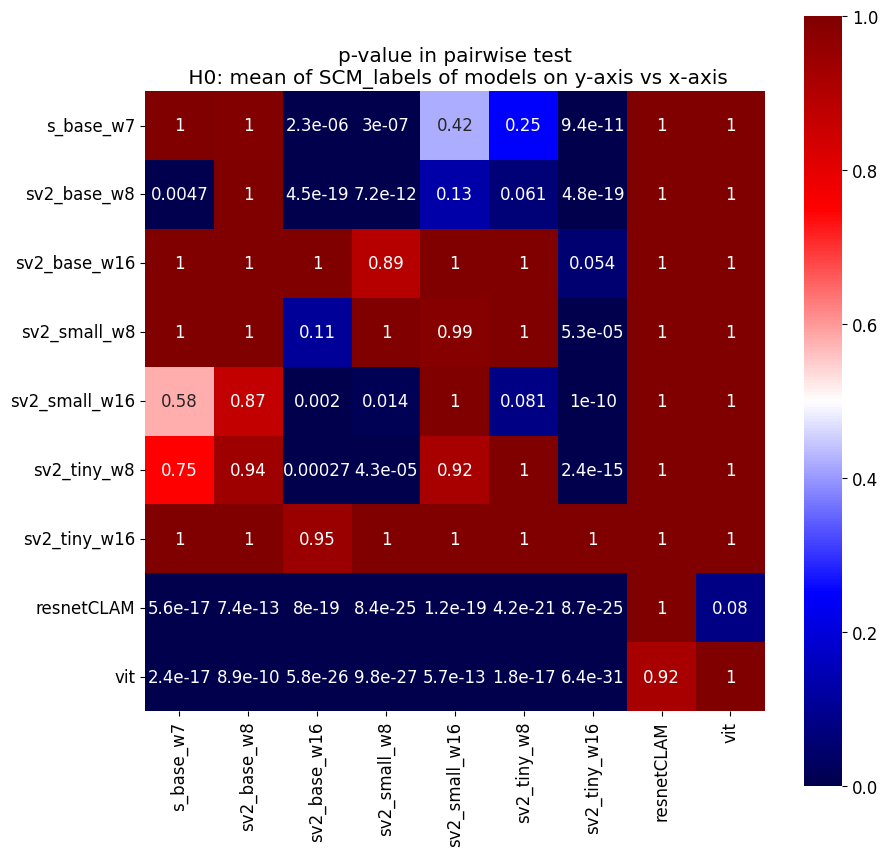

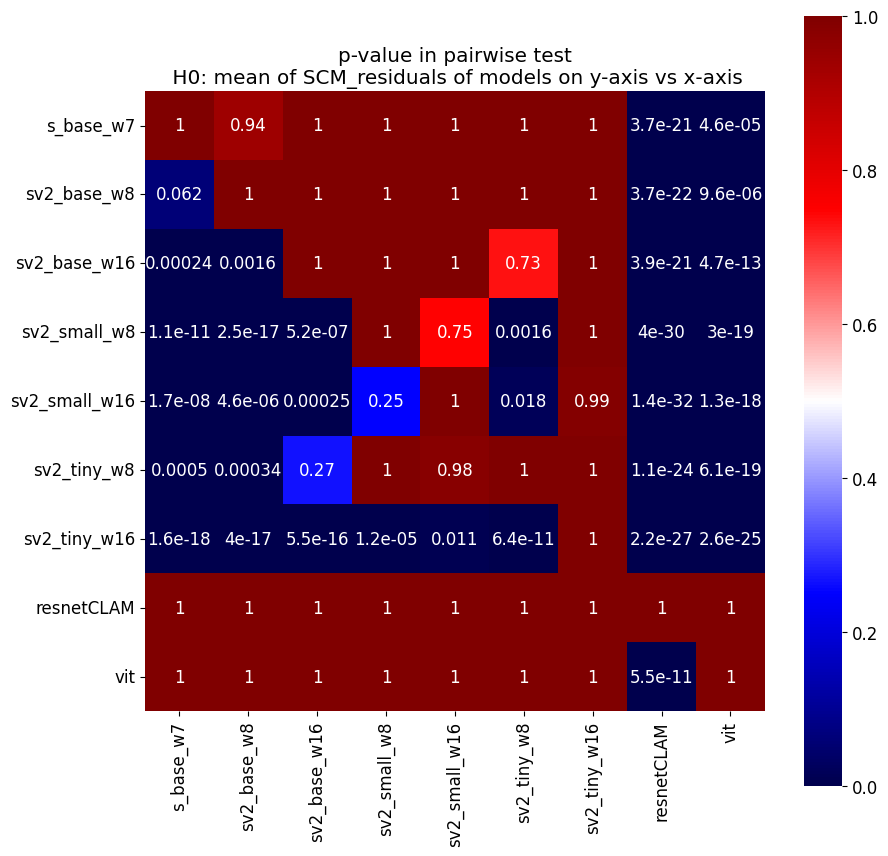

In [149]:
for metric in metric_names: 
    pairwise(d_per_images_test, metric, 'mean') 

## k vs tumor spread

In [151]:
dfs=dfs_test

list_spatial_count={}
list_spatial_names={}
list_spatial_k={}
list_SCM_labels=[{} for i in range(len(ks))] 
list_SCM_features=[{} for i in range(len(ks))] 
k_dict={8:0, 24:1, 48:2, 99:3}

def initialize_dicts(name, list_SCM_features, list_SCM_labels):
    for i in range(len(ks)):
        list_SCM_features[i][name]=[]
        list_SCM_labels[i][name]=[]
    return  list_SCM_features, list_SCM_labels

def extend_dicts(df, name, list_SCM_features, list_SCM_labels, k):
    list_SCM_features[k_dict[k]][name].extend([df[df.filename==name].loc[:,'SCM_features'].values[0]])
    list_SCM_labels[k_dict[k]][name].extend([df[df.filename==name].loc[:,'SCM_labels'].values[0]])
    return  list_SCM_features, list_SCM_labels
    

for i, df in enumerate(dfs):
    a=df[df.label==1]
    for name in a.filename.values:
        k=int(sorted(filelist)[5*i].split('/')[-1].split('_')[1])
        if name not in list_spatial_count.keys():
            list_spatial_count[name]=1
            list_spatial_names[name]=[sorted(filelist)[5*i].split('/')[-1]]
            list_spatial_k[name]=[k]

            list_SCM_features, list_SCM_labels=initialize_dicts(name, list_SCM_features, list_SCM_labels)
            
            extend_dicts(a, name, list_SCM_features, list_SCM_labels, k)

        else:
            list_spatial_count[name]+=1
            list_spatial_names[name].append(sorted(filelist)[5*i].split('/')[-1])
            list_spatial_k[name].append(int(sorted(filelist)[5*i].split('/')[-1].split('_')[1]))
            
            extend_dicts(a, name, list_SCM_features, list_SCM_labels, k)

In [152]:
def mean_list(list_SCM_labels, list_SCM_features, key):
    resulting_mean_list=[]
    for l in [list_SCM_labels, list_SCM_features]:
        for i in range(len(ks)):
            resulting_mean_list.append(np.mean(l[i][key]))
    return resulting_mean_list
            
most_spatial={key:
              patches_per_tumor_224[key.split('.')[0]]+
              [v]+
              [np.mean(list_spatial_k[key])]+
              mean_list(list_SCM_labels, list_SCM_features, key)
            for key, v in sorted(list_spatial_count.items(), reverse=True, key=lambda item: item[1]) 
              if key.split('.')[0] in patches_per_tumor_224}

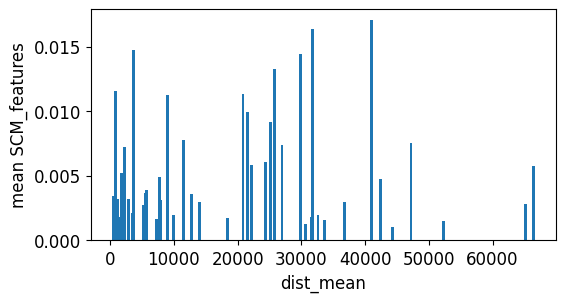

In [153]:
most_spatial_sorted={k: v for k, v in sorted(most_spatial.items(), key=lambda item: item[1][1])}   

mean_dist=np.array([el[1] for el in most_spatial_sorted.values()])
SCM_features_k99=np.array([el[-1] for el in most_spatial_sorted.values()])

width=450

plt.figure(figsize=(6,3))
plt.bar(mean_dist,diff_wx_k99 , width) 
plt.xlabel('dist_mean')
plt.ylabel('mean SCM_features')
plt.savefig(PATH_save_plots+'mean SCM_features_widespread_k99.png',  dpi=300, bbox_inches='tight')

# Correlation between mean_dist and metric measures given $k$ 

In [154]:
for i, metric in enumerate(metric_names[:2][::-1]):
    for k in ks:
        idx=k_dict[k]
        if i>0:
            idx=idx+len(ks)
        a=np.array([el[4+idx] for el in most_spatial_sorted.values()])
        corr=np.corrcoef(mean_dist, a)
        print(f"{metric}, k={k}, corr={corr[1,0]}")

SCM_labels, k=8, corr=0.21748661706278782
SCM_labels, k=24, corr=0.23446305440724974
SCM_labels, k=48, corr=0.23848245669043228
SCM_labels, k=99, corr=0.23551235653122243
SCM_features, k=8, corr=0.08327190575705849
SCM_features, k=24, corr=0.11520279376251312
SCM_features, k=48, corr=0.13274045488908812
SCM_features, k=99, corr=0.12488846788709587


# Most spatial

In [193]:
def extract_img_details(df, list_SCM_features, list_SCM_labels, list_spatial_count, list_spatial_names, list_spatial_k):
    for name in df.filename.values:
        k=int(sorted(filelist)[5*i].split('/')[-1].split('_')[1])
        if name not in list_spatial_count.keys():
            list_spatial_count[name]=1
            list_spatial_names[name]=[sorted(filelist)[5*i].split('/')[-1]]
            list_spatial_k[name]=[k]
            list_SCM_features, list_SCM_labels=initialize_dicts(name, list_SCM_features, list_SCM_labels)
            extend_dicts(df, name, list_SCM_features, list_SCM_labels, k)

        else:
            list_spatial_count[name]+=1
            list_spatial_names[name].append(sorted(filelist)[5*i].split('/')[-1])
            list_spatial_k[name].append(int(sorted(filelist)[5*i].split('/')[-1].split('_')[1]))
            extend_dicts(df, name, list_SCM_features, list_SCM_labels, k)
    return [list_SCM_features, list_SCM_labels, list_spatial_count, list_spatial_names, list_spatial_k]
    
list_spatial_count, list_spatial_names={}, {}
list_spatial_k={}
list_SCM_labels=[{} for i in range(len(ks))] 
list_SCM_features=[{} for i in range(len(ks))] 

list_spatial_count_rest, list_spatial_names_rest={}, {}
list_spatial_k_rest={}
list_SCM_labels_rest=[{} for i in range(len(ks))] 
list_SCM_features_rest=[{} for i in range(len(ks))]

for i, df in enumerate(dfs):
    percentile_95_1 = np.percentile(df[df.label==0]['SCM_labels'], 95)
    a=df[df.label==1][df.SCM_labels>percentile_95_1]
    a_rest=df[df.label==1][df.SCM_labels<=percentile_95_1]
    
    details_img_models=extract_img_details(a, list_SCM_features, list_SCM_labels, list_spatial_count, 
                                           list_spatial_names, list_spatial_k)
    list_SCM_features, list_SCM_labels, list_spatial_count, list_spatial_names, list_spatial_k=details_img_models
    
    details_img_models_rest=extract_img_details(a_rest, list_SCM_features_rest, list_SCM_labels_rest, 
                                                list_spatial_count_rest, list_spatial_names_rest, list_spatial_k_rest)
    list_SCM_features_rest, list_SCM_labels_rest, list_spatial_count_rest, list_spatial_names_rest, list_spatial_k_rest=details_img_models_rest
            

In [196]:
def mean_list_global(list_SCM_labels, list_SCM_features, key):
    resulting_mean_list=[]
    for l in [list_SCM_labels, list_SCM_features]:
        resulting_mean_list_l=[]
        for i in range(len(ks)):
            resulting_mean_list_l.extend(l[i][key])
        resulting_mean_list.append(np.mean(resulting_mean_list_l))
            
    return resulting_mean_list

most_spatial={key:patches_per_tumor_224[key.split('.')[0]]+
              [v]+
              [np.mean(list_spatial_k[key])]+
            mean_list_global(list_SCM_labels, list_SCM_features, key)
            for key, v in sorted(list_spatial_count.items(), reverse=True, 
                                 key=lambda item: item[1]) if key.split('.')[0] in patches_per_tumor_224}

least_spatial={key:patches_per_tumor_224[key.split('.')[0]]+
              [v]+
              [np.mean(list_spatial_k_rest[key])]+
            mean_list_global(list_SCM_labels_rest, list_SCM_features_rest, key)
            for key, v in sorted(list_spatial_count_rest.items(), reverse=True, 
                                 key=lambda item: item[1]) if key.split('.')[0] in patches_per_tumor_224}

In [197]:
for (key,v) in most_spatial.items():
    if v[2] > (9*4/2): #if image is chosen by more than half of model-k combinations
        if key in least_spatial.keys():
            del least_spatial[key]

In [201]:
for (key,v) in least_spatial.items(): 
    if key in most_spatial.keys():
        del most_spatial[key]

In [202]:
most_spatial.keys() & least_spatial.keys()

set()

Text(0, 0.5, 'log (dist_mean)')

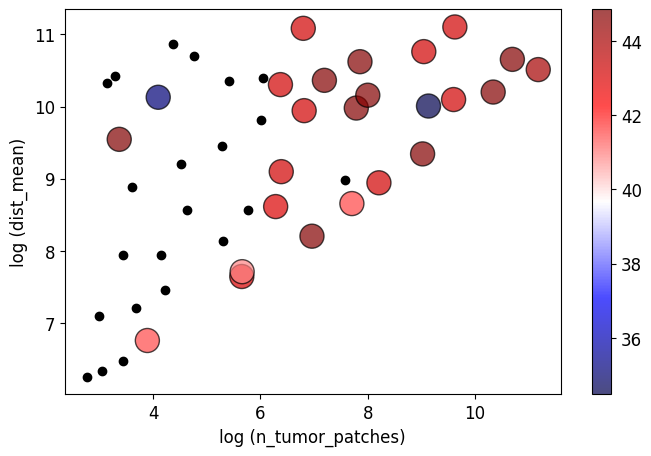

In [203]:
f=plt.figure(figsize=(8,5))
scatter=plt.scatter(np.log([el[0] for el in most_spatial.values()]),
                    np.log([el[1] for el in most_spatial.values()]), 
                    c=[el[3] for el in most_spatial.values()],
                    s=300, 
                    alpha=0.7, cmap='seismic',
                    edgecolors='black')
f.colorbar(scatter)


scatter=plt.scatter(np.log([el[0] for el in least_spatial.values()]),
                    np.log([el[1] for el in least_spatial.values()]), 
                    c='black')
plt.xlabel('log (n_tumor_patches)')
plt.ylabel('log (dist_mean)')
plt.savefig(PATH_save_plots+'most_spatial.png', dpi=300, bbox_inches='tight')

# DOTĄD POPRAWIŁAM

## Critical difference plot
(source: https://github.com/hfawaz/cd-diagram/tree/master  with some adjustments)

In [210]:
# Author: Hassan Ismail Fawaz <hassan.ismail-fawaz@uha.fr>
#         Germain Forestier <germain.forestier@uha.fr>
#         Jonathan Weber <jonathan.weber@uha.fr>
#         Lhassane Idoumghar <lhassane.idoumghar@uha.fr>
#         Pierre-Alain Muller <pierre-alain.muller@uha.fr>
# License: GPL3

import numpy as np
import pandas as pd
import matplotlib

matplotlib.use('agg')
import matplotlib.pyplot as plt

import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx

# inspired from orange3 https://docs.orange.biolab.si/3/data-mining-library/reference/evaluation.cd.html
def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, labels=False, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
        labels (bool, optional): if set to `True`, the calculated avg rank
        values will be displayed
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=2)

    bigtick = 0.3
    smalltick = 0.15
    linewidth = 2.0
    linewidth_sign = 4.0

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=2)

    acc_mean=df_perf.groupby('classifier_name')['test_global_acc'].agg(['mean', 'std'])
    ddd_mean=[acc_mean.loc[i]['mean'] for i in nnames] 
    ddd_std=[acc_mean.loc[i]['std'] for i in nnames] 
    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    
    ### pad numbers: np.pad(A, (2, 3), 'constant')  !!!!!!!!!!!!!
    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="right", va="center", size=10)
        text(textspace - 0.2, chei, 
             filter_names(nnames[i])+":"+str(np.round(ddd_mean[i]*100, 1))+u"\u00B1"+str(np.round(ddd_std[i]*100, 1)), 
             ha="right", va="center", size=16)

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + scalewidth - 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="left", va="center", size=10)
        text(textspace + scalewidth + 0.2, chei, 
             filter_names(nnames[i])+":"+str(np.round(ddd_mean[i]*100, 1))+u"\u00B1"+str(np.round(ddd_std[i]*100, 1)),
             ha="left", va="center", size=16)

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            print('drawing: ', l, r)

    # draw_lines(lines)
    start = cline + 0.2
    side = -0.02
    height = 0.1

    # draw no significant lines
    # get the cliques
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    for clq in cliques:
        if len(clq) == 1:
            continue
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign)
        start += height


def form_cliques(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)


def draw_cd_diagram(df_perf=None, alpha=0.05, title=None, labels=False):
    """
    Draws the critical difference diagram given the list of pairwise classifiers that are
    significant or not
    """
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, alpha=alpha)

    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=6, textspace=1.5, labels=labels)

    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    plt.savefig('cd-diagram.png',bbox_inches='tight')

def wilcoxon_holm(alpha=0.05, df_perf=None):
    """
    Applies the wilcoxon signed rank test between each pair of algorithm and then use Holm
    to reject the null's hypothesis
    """
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['classifier_name']).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    # get the list of classifiers who have been tested on nb_max_datasets
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['classifier_name'])
    # test the null hypothesis using friedman before doing a post-hoc analysis
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
        for c in classifiers))[1]
    if friedman_p_value >= alpha:
        # then the null hypothesis over the entire classifiers cannot be rejected
        print('the null hypothesis over the entire classifiers cannot be rejected')
        exit()
    # get the number of classifiers
    m = len(classifiers)
    # init array that contains the p-values calculated by the Wilcoxon signed rank test
    p_values = []
    # loop through the algorithms to compare pairwise
    for i in range(m - 1):
        # get the name of classifier one
        classifier_1 = classifiers[i]
        # get the performance of classifier one
        perf_1 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_1]['accuracy']
                          , dtype=np.float64)
        for j in range(i + 1, m):
            # get the name of the second classifier
            classifier_2 = classifiers[j]
            # get the performance of classifier one
            perf_2 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_2]
                              ['accuracy'], dtype=np.float64)
            # calculate the p_value
            p_value = wilcoxon(perf_1, perf_2, zero_method='pratt')[1]
            # append to the list
            p_values.append((classifier_1, classifier_2, p_value, False))
    # get the number of hypothesis
    k = len(p_values)
    # sort the list in acsending manner of p-value
    p_values.sort(key=operator.itemgetter(2))

    # loop through the hypothesis
    for i in range(k):
        # correct alpha with holm
        new_alpha = float(alpha / (k - i))
        # test if significant after holm's correction of alpha
        if p_values[i][2] <= new_alpha:
            p_values[i] = (p_values[i][0], p_values[i][1], p_values[i][2], True)
        else:
            # stop
            break
    # compute the average ranks to be returned (useful for drawing the cd diagram)
    # sort the dataframe of performances
    sorted_df_perf = df_perf.loc[df_perf['classifier_name'].isin(classifiers)]. \
        sort_values(['classifier_name', 'dataset_name'])
    # get the rank data
    rank_data = np.array(sorted_df_perf['accuracy']).reshape(m, max_nb_datasets)

    # create the data frame containg the accuracies
    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=
    np.unique(sorted_df_perf['dataset_name']))

    # number of wins
    dfff = df_ranks.rank(ascending=False)

    # average the ranks
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    # return the p-values and the average ranks
    return p_values, average_ranks, max_nb_datasets

In [211]:
df_perf = pd.read_csv('wandb_results.csv', index_col=False)
df_perf['classifier_name']=df_perf['results_dir'].str.split('/').str[-1].str[15:-60]
df_perf=df_perf[~df_perf.classifier_name.str.contains('pcam')]
df_perf['classifier_name']=[i.replace('patch4_','') if 'patch4_' in i else i for i in df_perf['classifier_name']]
df_perf['classifier_name']=[i.replace('_256','') if '_256' in i else i for i in df_perf['classifier_name']]
df_perf['classifier_name']=[i.replace('_224','') if '_224' in i else i for i in df_perf['classifier_name']]
df_perf['classifier_name']=[i.replace('_22k','') if '_22k' in i else i for i in df_perf['classifier_name']]
df_perf['classifier_name']=[i.replace('_wei','') if 'wei' in i else i for i in df_perf['classifier_name']]

df_perf['classifier_name']=[i.replace('swin','s') if 'swin' in i else i for i in df_perf['classifier_name']]
df_perf['classifier_name']=[i.replace('window','w') if 'window' in i else i for i in df_perf['classifier_name']]
## above 2 changes for brevity

df_perf['accuracy']=df_perf['test_global_acc']
df_perf['dataset_name']=df_perf['Name'].str.split('_').str[-6]


draw_cd_diagram(df_perf=df_perf, title='Accuracy ranking', labels=False)